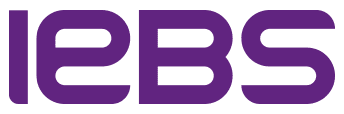

# **Global Project - Máster en Data science y Big Data**

## **Identificar transacciones fraudulentas de tarjetas de crédito utilizando una Red Neuronal Convolucional.**

### **Alumno:** Brandon Uriel Palacios Méndez

Reconocer transacciones fraudulentas de transacciones legititmas ha sido un desafío para los negocios, se ha convertido en una actividad diaria para todas las empresas, especialmente las tecnológicas.

Algunos de los beneficios clave de la detección de fraude son:

* **Proteger la reputación del negocio.** Reduce los riesgos impactar en la reputación pública de una empresa.

* **Mejorar la satisfacción del cliente.** Proteger la información personal de los clientes.

* **Prevenir transacciones no autorizadas.**

El objetivo de este análisis es crear un modelo eficiente para la probabilidad de que una transacción pueda ser fraudulenta.

El [dataset](https://www.kaggle.com/datasets/sanskar457/fraud-transaction-detection) a utilizar, contiene transacciones de pagos con tarjeta de crédito en diferentes terminales de Europa del periodo de Enero 2023 a Junio 2023.

In [1]:
# Importamos las librearias necesarias para la realización del proyecto.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Procesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

print(tf.__version__)

2.13.0


## **Fase 1.** Recolección de datos

In [2]:
#Cargamos el dataset desde Kaggle ya que tamaño del archivo es muy grande
from google.colab import files
!pip install -q kaggle

# Subimos kaggle.json con el cliente
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
# Movemos el archivo a la ubicación correcta.
!mv kaggle.json /root/.kaggle/kaggle.json

In [6]:
# Descargamos dataset
!kaggle datasets download -d sanskar457/fraud-transaction-detection

 97% 33.0M/34.0M [00:02<00:00, 19.0MB/s]
100% 34.0M/34.0M [00:02<00:00, 12.8MB/s]


In [7]:
# Descomprimimos el datset
!unzip fraud-transaction-detection.zip

Archive:  fraud-transaction-detection.zip
  inflating: Final Transactions.csv  


In [8]:
# Creamos el dataframe
data = pd.read_csv('Final Transactions.csv')
data.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


Podemos observar que solo obtuvimos datos estadísticos de 13 de las 17 columnas del dataframe, lo cuál nos idica que existen variables de tipo Object, lo cual se revisará a continuación.

## **Fase 2.** Análisis Exploratorio

In [9]:
# Consultamos el tipo de variables del dataset
data.dtypes

Unnamed: 0             int64
TRANSACTION_ID         int64
TX_DATETIME           object
CUSTOMER_ID            int64
TERMINAL_ID            int64
TX_AMOUNT            float64
TX_TIME_SECONDS        int64
TX_TIME_DAYS           int64
TX_FRAUD               int64
TX_FRAUD_SCENARIO      int64
dtype: object

In [10]:
# Consultamos el número de filas y columnas
data.shape

(1754155, 10)

In [11]:
# Consultamos si tenemos celdas sin valor
data.isnull().sum()

Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [12]:
# Revisamos el número de valores que tenemos en la variante 'TX_FRAUD',
# en la cuál 0, representa que no hubo fraude y 1 representa fraude.
data['TX_FRAUD'].value_counts()

0    1518186
1     235969
Name: TX_FRAUD, dtype: int64

### Balance del dataset

Realizaremos un balance al dataframe con el fin de que el desbalance no afecte el modelo y no tengamos overfitting.

Para realizar el balance, se tomará una muestra de datos aleatorios del tamaño de la cantidad de datos que tenemos con fraude.

In [13]:
# Creamos 2 variables para separar los datos que contienen datos con fraude y sin fraude
no_fraud = data[data['TX_FRAUD']==0]
fraud = data[data['TX_FRAUD']==1]

In [14]:
# Comprobamos el tamaño de ambos df
no_fraud.shape, fraud.shape

((1518186, 10), (235969, 10))

In [15]:
# Tomamos una muestra aleatoria de los datos que no son fraudulentos del mismo tamaño que los fraudulentos.
no_fraud = no_fraud.sample(fraud.shape[0])
no_fraud.shape

(235969, 10)

In [16]:
# Unimos ambos df dentro de la variable data
data = fraud.append(no_fraud, ignore_index= True)
data.sample(10)

<ipython-input-16-e2d6c95dddb5>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = fraud.append(no_fraud, ignore_index= True)


,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
277375,86371,86371,2023-01-10 02:04:41,4116,8070,450.61,785081,9,0,0
254146,667341,667341,2023-03-11 13:03:51,2255,7217,636.14,6008631,69,0,0
409925,1362742,1362742,2023-05-23 06:40:34,1445,2861,270.94,12292834,142,0,0
57457,431350,431350,2023-02-14 20:46:13,1554,2414,1592.80,3876373,44,1,1
328695,195243,195243,2023-01-21 10:24:43,2134,6596,349.17,1765483,20,0,0
331007,1213858,1213858,2023-05-07 13:34:12,1249,3456,574.27,10935252,126,0,0
59254,444783,444783,2023-02-16 09:39:18,2615,2211,1355.81,4009158,46,1,1
386780,276065,276065,2023-01-29 15:50:07,61,4843,872.52,2476207,28,0,0
243177,1715470,1715470,2023-06-28 20:02:14,4881,6383,484.74,15451334,178,0,0
169232,1261457,1261457,2023-05-12 12:54:02,699,4979,1031.59,11364842,131,1,1


1    235969
0    235969
Name: TX_FRAUD, dtype: int64


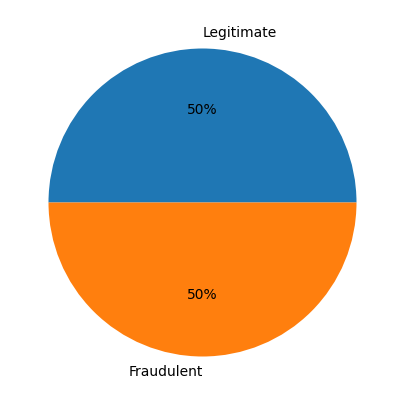

In [17]:
#Comprobamos balance del dataset
data['TX_FRAUD'].value_counts()

a, b = data['TX_FRAUD'].value_counts()
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.pie([a, b], labels=['Legitimate', 'Fraudulent'], autopct='%1.0f%%')
print(data['TX_FRAUD'].value_counts())

Comprobamos que nuestro dataset data está balanceado y podemos proceder con el análisis.

### Exploración Visual

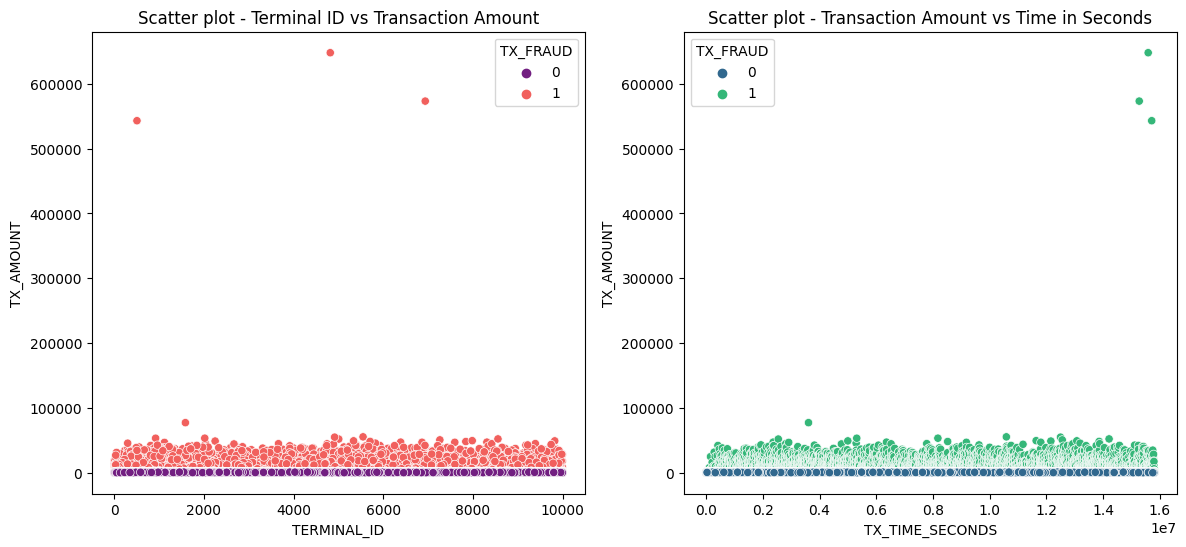

In [18]:
# Distribución de transacciones fraudulentas
f=  plt.figure(figsize=(14,6))
ax= f.add_subplot(121)
sns.scatterplot (x= 'TERMINAL_ID', y= 'TX_AMOUNT', data= data, palette= 'magma', hue= 'TX_FRAUD', ax= ax)
ax.set_title('Scatter plot - Terminal ID vs Transaction Amount')

ax= f.add_subplot(122)
sns.scatterplot(x= 'TX_TIME_SECONDS', y= 'TX_AMOUNT', data= data, palette= 'viridis', hue= 'TX_FRAUD')
ax.set_title('Scatter plot - Transaction Amount vs Time in Seconds')
plt.savefig('sc.png')

Podemos comprobar que las transacciones fraudulentas son generalmente pot valores altos, lo cual, nos da una perspectiva inicial de que sí una transacción es por un monto mayor al promedio, es probable que trate de un intento de fraude.

<ipython-input-19-db6a360eec86>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= data.corr()


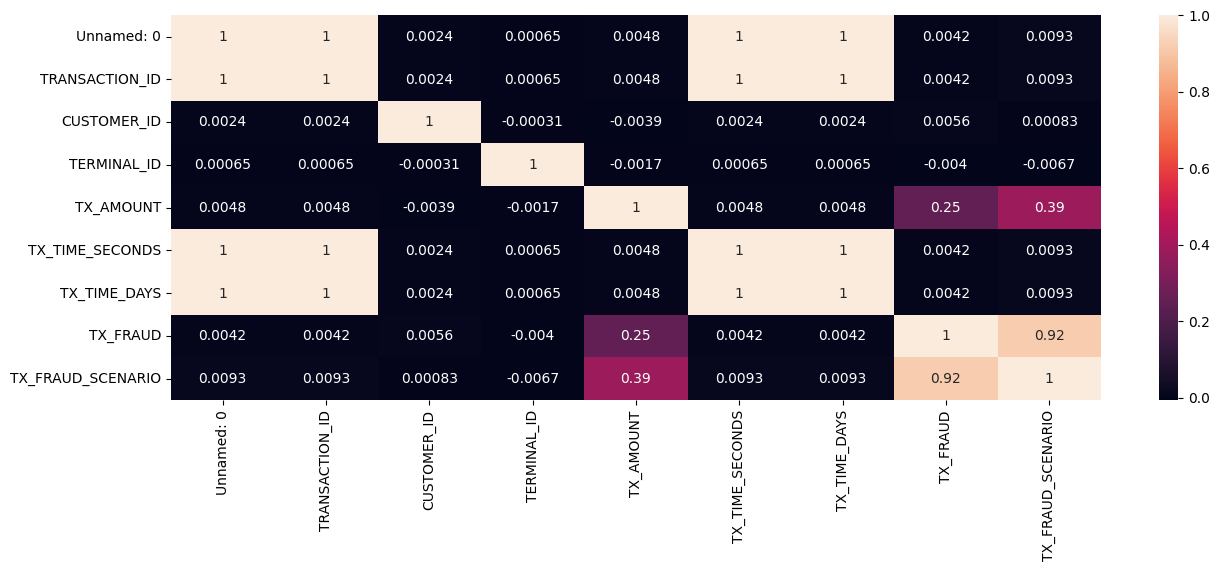

In [19]:
# Revisamos la correlación entre las variables
corr= data.corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot= True);

Podmeos observar que existe un alta correlación con las variables 'TX_FRAUD_SCENARIO' y con 'TX_TIME_DAYS', por lo cual las necesitamos remover del dataset para evitar overfitting.

In [18]:
# Eliminamos las variables con correlación.
data = data.drop(['TX_FRAUD_SCENARIO', 'TX_TIME_DAYS'], axis= 1)
data.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_FRAUD
0,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,1
1,20,20,2023-01-01 00:21:09,1270,931,1378.62,1269,1
2,23,23,2023-01-01 00:25:24,508,9687,1376.93,1524,1
3,35,35,2023-01-01 00:31:51,1753,8676,1145.15,1911,1
4,43,43,2023-01-01 00:34:45,3425,2930,1177.45,2085,1


In [19]:
# Eliminamos el resto de variables que no aportan valor al modelo
data = data.drop(['Unnamed: 0', 'TRANSACTION_ID', 'TX_DATETIME'], axis=1)
data.head()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_FRAUD
0,2,1365,1442.94,476,1
1,1270,931,1378.62,1269,1
2,508,9687,1376.93,1524,1
3,1753,8676,1145.15,1911,1
4,3425,2930,1177.45,2085,1


## Fase 3. Preprocesamiento de los datos

In [20]:
# Dividimos nuestros datos de entrenamiento y test
X = data.drop('TX_FRAUD', axis=1)
y = data['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
X_train.shape, X_test.shape

((377550, 4), (94388, 4))

In [22]:
# Realizamos la normalización de los valores utilizando StandardScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Transformamos los valores de 'y' a formato numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [24]:
# Redimensionamos los conjuntos de train y test para poder trabajar con las redes neuronales convolucionales
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape, X_test.shape

((377550, 4, 1), (94388, 4, 1))

### Construimos la Red Neuronal Convolucional

In [25]:
# Creamos la arquitectura
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, padding= 'same', activation= 'relu', input_shape= X_train[0].shape),
    tf.keras.layers.MaxPool1D(2, strides= 2, padding= 'same'),
    tf.keras.layers.Conv1D(32, 3, padding= 'same', activation= 'relu'),
    tf.keras.layers.MaxPool1D(2, strides= 2, padding= 'same'),
    tf.keras.layers.Conv1D(32, 3, padding= 'same', activation= 'relu'),
    tf.keras.layers.MaxPool1D(2, strides= 2, padding= 'same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.75),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

In [26]:
# Definimos el optimizer
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001)

# Compilamos el modelo
model.compile(optimizer= opt,
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])

#Entrenamos el modelo
hist = model.fit(X_train, y_train, validation_split= 0.2, epochs=20)

Epoch 1/20
9439/9439 [==============================] - 75s 7ms/step - loss: 0.2148 - accuracy: 0.9289 - val_loss: 0.1496 - val_accuracy: 0.9437
Epoch 2/20
9439/9439 [==============================] - 96s 10ms/step - loss: 0.1239 - accuracy: 0.9709 - val_loss: 0.1040 - val_accuracy: 0.9735
Epoch 3/20
9439/9439 [==============================] - 73s 8ms/step - loss: 0.1143 - accuracy: 0.9724 - val_loss: 0.0868 - val_accuracy: 0.9784
Epoch 4/20
9439/9439 [==============================] - 70s 7ms/step - loss: 0.1103 - accuracy: 0.9731 - val_loss: 0.0990 - val_accuracy: 0.9736
Epoch 5/20
9439/9439 [==============================] - 64s 7ms/step - loss: 0.1082 - accuracy: 0.9733 - val_loss: 0.0888 - val_accuracy: 0.9770
Epoch 6/20
9439/9439 [==============================] - 64s 7ms/step - loss: 0.1062 - accuracy: 0.9734 - val_loss: 0.0869 - val_accuracy: 0.9786
Epoch 7/20
9439/9439 [==============================] - 64s 7ms/step - loss: 0.1046 - accuracy: 0.9738 - val_loss: 0.1138 - val_a

### Evaluamos el modelo

2950/2950 [==============================] - 18s 6ms/step - loss: 0.1023 - accuracy: 0.9746


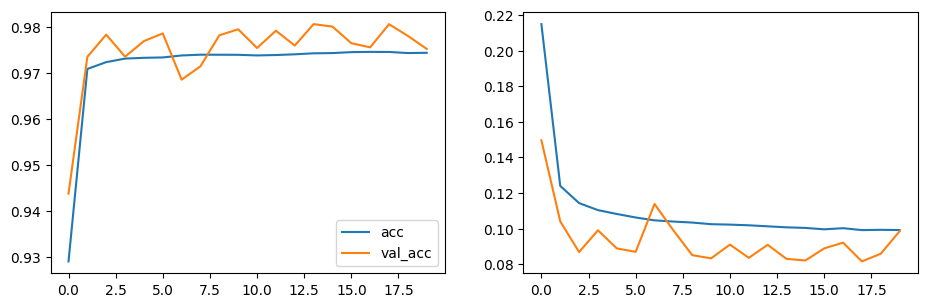

In [27]:
# Utilizamos la función evaluate()
model.evaluate(X_test, y_test)

# Visualizamos la gráfica
fig=plt.figure(figsize=(60, 40))

# Error
fig.add_subplot(10, 10, 2)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')

# Precisión
fig.add_subplot(10, 10, 1)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend()

plt.legend()

Después de entrenar y evaluar el modelo, observamos que se obtuvo un **accuracy del 97.46%** por lo que se puede concluir que el modelo es eficiente y funcional para realizar detecciones de transacciones fraudulentas, con una muy pequeña tasa de error.

In [28]:
# Guardamos nuestro modelo entrenado con el fin de utilizarlo en una página web.
tf.keras.models.save_model(model, 'cnn_model.hdf5')

<ipython-input-28-f899b0a380da>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, 'cnn_model.hdf5')
